In [ ]:
def normalize_rows(mtrx):
    assert isinstance(mtrx, np.ndarray) # Only numpy arrays as input
    norms = np.sqrt(np.sum(mtrx * mtrx, axis=1))
    mtrx_norm = np.repeat(norms.reshape([-1, 1]), mtrx.shape[1], axis=1)
    return 0.999 * mtrx / mtrx_norm # 0.999 guarantees values < 1.000 which causes NaNs in tf.acos

def spread_metric(tensor2d):
    """ Assumes all rows already normalized """
    
    total_tangential_force = tf.Variable(0.0)
    for this_idx in range(tensor2d.numpy().shape[0]):
        this_force_list = []
        for other_idx in range(tensor2d.numpy().shape[0]):
            if this_idx == other_idx:
                continue
            
            this_vec = tensor2d[this_idx, :]
            other_vec = tensor2d[other_idx, :]
            diff = this_vec - other_vec
            norm = tf.norm(diff)
            force_vec = diff / (norm + 1e-5)**3
            
            this_force_list.append(force_vec)
            
        force_sum = tf.reduce_sum(tf.stack(this_force_list), axis=0)
        r_dot_s = tf.tensordot(this_vec, force_sum, axes=1)
        r_dot_r = tf.tensordot(this_vec, this_vec, axes=1)
        radial_component = this_vec * r_dot_s / r_dot_r 
        tangent_force = tf.reduce_sum(tf.square(force_sum - radial_component))
        total_tangential_force = total_tangential_force + tangent_force
    
    return total_tangential_force
 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import ipywidgets as widgets
import seaborn as sns
from IPython.display import display
from tqdm.autonotebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sys
print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={keras.__version__}')
print("GPU Available: ", tf.test.is_gpu_available())


Using Python=3.7.2 (default, Mar 30 2019, 15:56:42) 
[GCC 5.4.0 20160609]
Using Tensorflow=2.1.0
Using Keras=2.2.4-tf
GPU Available:  False


In [68]:
class VectorSpread:
    def __init__(self, n_vec, dims=2):
        self.n_vec = n_vec
        self.vecs = np.random.normal(size=(n_vec, dims))
        self.norm_rows_inplace()
        self.spread_hist = []
        self.fig, self.ax = plt.subplots(figsize=(6,6))
    
    
    def norm_rows_inplace(self):
        # 0.999 guarantees values < 1.000 which causes NaNs in tf.acos
        self.vecs = 0.999 * keras.utils.normalize(self.vecs, axis=1)

        
    @staticmethod
    def spread_metric(tensor2d):
        """ Assumes all rows already normalized """
        angle_pairs = tf.acos(tensor2d @ tf.transpose(tensor2d))
        disable_diag = tf.eye(tensor2d.numpy().shape[0]) * 2 * np.pi
        return tf.reduce_min(angle_pairs + disable_diag)    
    
    
    def plot_vecs(self, ax=None, title=None):
        if ax is None:
            ax = self.ax
            
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if title:
            ax.set_title(title)
        
        vec_xs = np.zeros(2*self.vecs.shape[0])
        vec_ys = np.zeros(2*self.vecs.shape[0])
        vec_xs[::2] = self.vecs[:, 0]
        vec_ys[::2] = self.vecs[:, 1]
        
        lines, = ax.plot(vec_xs, vec_ys, 'b-')
        red_pts = ax.scatter([0], [0], s=100, c='red')
        green_pts = ax.scatter(self.vecs[:, 0], self.vecs[:, 1], s=13.3, c='green')
            
        return lines, red_pts, green_pts
    
    
    def init_axes(self):
        self.ax.set_xlim(-1.2, 1.2)
        self.ax.set_ylim(-1.2, 1.2)
        self.ax.set_aspect('equal')
        self.ax.grid(False)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.line_data, = self.ax.plot([],[],'b-')
        self.red_pt_data = self.ax.scatter([0],[0], c='red', s=100)
        self.green_pt_data = self.ax.scatter([],[], c='green', s=15)
        return self.line_data, self.red_pt_data, self.green_pt_data
        
    def update_plot_data(self, i):
        self.one_iter(i)
        
        vec_xs = np.zeros(2*self.vecs.shape[0])
        vec_ys = np.zeros(2*self.vecs.shape[0])
        vec_xs[::2] = self.vecs[:, 0]
        vec_ys[::2] = self.vecs[:, 1]
        
        self.line_data.set_data(vec_xs, vec_ys)
        self.red_pt_data.set_offsets(np.zeros(shape=(1,2), dtype='float32'))
        self.green_pt_data.set_offsets(self.vecs)
            
        return self.line_data, self.red_pt_data, self.green_pt_data
    
    def one_iter(self, i, learning_rate=0.01):
        self.norm_rows_inplace()
        tfvecs = tf.convert_to_tensor(self.vecs, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tfvar = tf.Variable(tfvecs)
            spread = self.spread_metric(tfvar)

        grads = tape.gradient(spread, tfvar)
        self.vecs += learning_rate * grads.numpy()
        self.spread_hist.append(spread.numpy())
        self.norm_rows_inplace()
        
    def run_animation_code(self):
        anim = animation.FuncAnimation(self.fig, func=self.update_plot_data, init_func=self.init_axes, frames=n_iter, interval=10)
        anim.save('test_out.mp4')
        


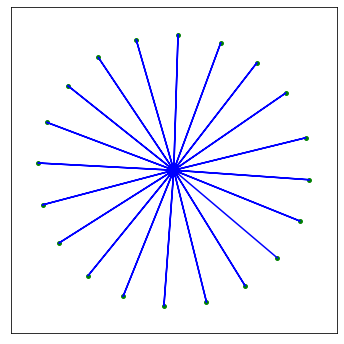

In [69]:
vs = VectorSpread(20)
n_iter = 1000
learning_rate = 0.01
vs.run_animation_code()



In [58]:
k = np.array(range(10))
j = np.array(range(20)) + 3
print(j, k)
j[::2] = k
print(j)

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [0 1 2 3 4 5 6 7 8 9]
[ 0  4  1  6  2  8  3 10  4 12  5 14  6 16  7 18  8 20  9 22]


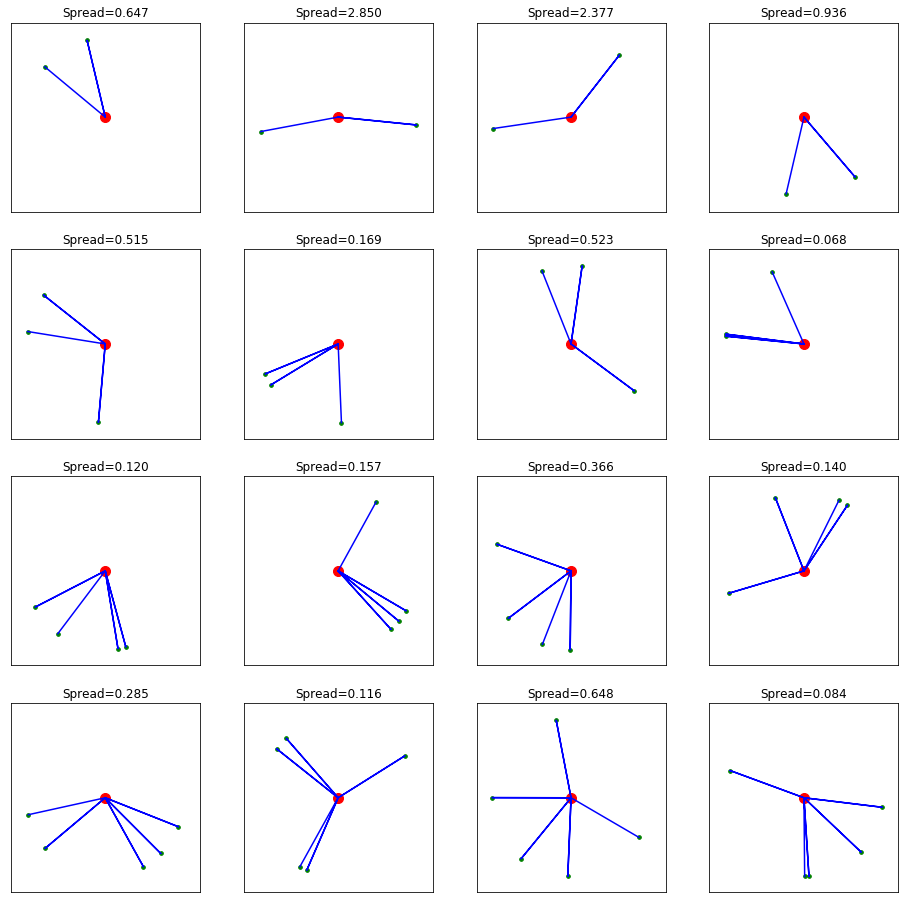

In [59]:
sr,sc = 4,4
fig,axs = plt.subplots(sr, sc, figsize=(4*sc, 4*sr))

for r in range(sr):
    for c in range(sc):
        vs = VectorSpread(r+2)
        spread = VectorSpread.spread_metric(tf.convert_to_tensor(vs.vecs, dtype='float32'))
        
        vs.plot_vecs(ax=axs[r][c], title=f'Spread={spread:.3f}')
                



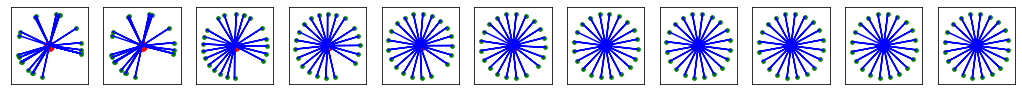

In [54]:
vs = VectorSpread(20)
n_iter = 10000
fig,axs = plt.subplots(1, 11, figsize=(18, 4))
learning_rate = 0.01

vs.plot_vecs(ax=axs[0])
for i in range(10):
    for j in range(n_iter//10):
        vs.one_iter(i*10 + j, learning_rate=0.005)
        if j == 0:
            vs.plot_vecs(ax=axs[i+1])
    learning_rate *= 0.2


Line2D(_line0)


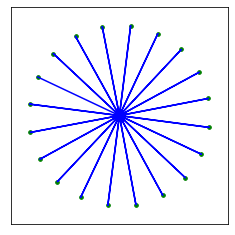

In [55]:
for lst in vs.plot_vecs():
    print(lst)

In [ ]:
vs = VectorSpread(20)
n_iter = 10000
fig,ax = plt.subplots(figsize=(7,7))
learning_rate = 0.01
os.makedirs('images_2d', exist_ok=True)


vs.norm_rows_inplace()
for j in range(n_iter+1):
    vs.one_iter(j, learning_rate=0.01)
    ax.clear()
    if j % 50 == 0:
        vs.plot_vecs(ax=ax)
        fig.savefig(os.path.join('images_2d', f'img_{j:05d}.png'))
        learning_rate *= 0.995
        

#anim = animation.FuncAnimation(fig, animate, frames=n_iter//10, interval=10, fargs=[vs, n_iter])
#anim.save('test_out.mp4')

In [ ]:
import imageio


In [ ]:
anim.save('test_out.mp4')

In [ ]:
vecs = np.random.normal(size=(6, 3)).astype('float32')
print(vecs)
vecs = keras.utils.normalize(vecs, axis=1)
vecs = keras.utils.normalize(vecs, axis=1)
vecs = keras.utils.normalize(vecs, axis=1)
vecs = keras.utils.normalize(vecs, axis=1)
print(vecs, np.sum(vecs*vecs, axis=1))


In [ ]:
vecs = np.random.normal(size=(20, 3)).astype('float32')
learning_rate = 0.005
min_angle_collect = []
eps = 0.01
n_iter = 10000

print(vecs)

for i in range(n_iter):
    #vecs = tf.linalg.normalize(vecs, axis=1)[0]
    vecs = keras.utils.normalize(vecs, axis=1)
    print(vecs)
    
    if i%(n_iter / 10) == 0:
        # Reduce learning-rate and plot current state
        #learning_rate *= 0.98
        plot_vecs_3d(vecs)
        

    tfvecs = tf.convert_to_tensor(vecs, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tfvar = tf.Variable(tfvecs)
        spread = spread_metric(tfvar)
        min_angle_collect.append(spread)
        
    grads = tape.gradient(spread, tfvar)
    vecs += learning_rate * grads.numpy()
    
vecs = keras.utils.normalize(vecs, axis=1)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(min_angle_collect)
ax.set_xlabel('Iterations')
ax.set_ylabel('Minimum angle')
ax.set_title('Maximizing the minimum angle size')



In [ ]:
def create_multi_cos_data(fpa_list, quad_ramp, noise_std, periods, num_pts=1000):
    """
    FPA ~ (Freq, Phase, Amplitude)
    """
    xs = np.linspace(0, periods*np.pi / fpa_list[0][0], num=num_pts)
    noise = np.random.normal(0, noise_std, size=xs.shape)
    
    ys = quad_ramp * xs**2 + noise
    for i in range(fpa_list.shape[0]):
        freq, phase, ampl = fpa_list[i, :].tolist()
        ys += ampl * np.cos(freq * xs - phase)
    
    return (xs, ys)

In [ ]:
fpa_in = np.array([
    [3.5, 0.0, 60],
    [5.0, 0.0, 40],
])

xs, ys = create_multi_cos_data(fpa_in, quad_ramp=20.9, noise_std=40.0, periods=4, num_pts=2000)
xt, yt = create_multi_cos_data(fpa_in, quad_ramp=20.9, noise_std=0.0, periods=4, num_pts=2000)
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(xs, ys, ax=ax)

In [ ]:
fpa_guess = np.array([
    [0.2,  0.0,  12.0],
    [1.5,  0.0,   3.0],
    #[8.0,  0.0, 100.0],
])
quad_ramp = 1.0

domain = tf.convert_to_tensor(xs, dtype=tf.float32)
y_data = tf.convert_to_tensor(ys, dtype=tf.float32)

freq_1 = tf.Variable(2, dtype=tf.float32)
freq_2 = tf.Variable(7, dtype=tf.float32)
ampl_1 = tf.Variable(10, dtype=tf.float32)
ampl_2 = tf.Variable(20, dtype=tf.float32)
quad_coef = tf.Variable(10.0, dtype=tf.float32)

losses = []
var_vals = []
learning_rate = 0.001
non_equal_freq_factor = 1.0
lr_decay = 0.999

for i in range(500):
    if i%50==0:
        fig, axs = plt.subplots(1,2, figsize=(12,5))
        axs[0].scatter(xs, ys)
        axs[0].plot(xt, yt, 'r-.')
        axs[0].set_ylim(-250,500)
    
    with tf.GradientTape() as tape:
        tape.watch([freq_1, freq_2, ampl_1, ampl_2, quad_coef])
        pred_y = ampl_1 * tf.cos(freq_1 * domain) + \
                 ampl_2 * tf.cos(freq_2 * domain) + \
                 quad_coef * tf.square(domain)
        
        if i%50==0:
            axs[1].plot(xs, pred_y.numpy())
            axs[1].set_ylim(-250,500)
            
        loss = tf.reduce_mean((pred_y - y_data)**2)
        loss += non_equal_freq_factor / (freq_1 - freq_2)**2
        
    grads = tape.gradient(loss, [freq_1, freq_2, ampl_1, ampl_2, quad_coef])
    
    freq_1.assign_sub(learning_rate * grads[0])
    freq_2.assign_sub(learning_rate * grads[1])
    ampl_1.assign_sub(learning_rate * grads[2])
    ampl_2.assign_sub(learning_rate * grads[3])
    quad_coef.assign_sub(learning_rate * grads[4])
    
    learning_rate *= lr_decay
    
    losses.append(loss.numpy())
    var_vals.append([freq_1.numpy(), freq_2.numpy(), ampl_1.numpy(), ampl_2.numpy(), quad_coef.numpy()])
    
        
fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(losses)
for pent in var_vals:
    print(pent)
        
    

In [ ]:

domain = tf.convert_to_tensor(xs, dtype=tf.float32)
y_data = tf.convert_to_tensor(ys, dtype=tf.float32)

freq_1 = tf.Variable(2, dtype=tf.float32)
freq_2 = tf.Variable(7, dtype=tf.float32)
ampl_1 = tf.Variable(10, dtype=tf.float32)
ampl_2 = tf.Variable(20, dtype=tf.float32)
quad_coef = tf.Variable(10.0, dtype=tf.float32)

losses = []
var_vals = []
learning_rate = 0.001
non_equal_freq_factor = 1.0
lr_decay = 0.999

for i in range(500):
    if i%50==0:
        fig, axs = plt.subplots(1,2, figsize=(12,5))
        axs[0].scatter(xs, ys)
        axs[0].plot(xt, yt, 'r-.')
        axs[0].set_ylim(-250,500)
    
    with tf.GradientTape() as tape:
        tape.watch([freq_1, freq_2, ampl_1, ampl_2, quad_coef])
        pred_y = ampl_1 * tf.cos(freq_1 * domain) + \
                 ampl_2 * tf.cos(freq_2 * domain) + \
                 quad_coef * tf.square(domain)
        
        if i%50==0:
            axs[1].plot(xs, pred_y.numpy())
            axs[1].set_ylim(-250,500)
            
        loss = tf.reduce_mean((pred_y - y_data)**2)
        loss += non_equal_freq_factor / (freq_1 - freq_2)**2
        
    grads = tape.gradient(loss, [freq_1, freq_2, ampl_1, ampl_2, quad_coef])
    
    freq_1.assign_sub(learning_rate * grads[0])
    freq_2.assign_sub(learning_rate * grads[1])
    ampl_1.assign_sub(learning_rate * grads[2])
    ampl_2.assign_sub(learning_rate * grads[3])
    quad_coef.assign_sub(learning_rate * grads[4])
    
    learning_rate *= lr_decay
    
    losses.append(loss.numpy())
    var_vals.append([freq_1.numpy(), freq_2.numpy(), ampl_1.numpy(), ampl_2.numpy(), quad_coef.numpy()])
    
        
fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(losses)
for pent in var_vals:
    print(pent)
        
    

In [ ]:
fpa_guess = np.array([
    [0.2,  0.0,  12.0],
    [1.5,  0.0,   3.0],
    #[8.0,  0.0, 100.0],
])
quad_ramp = 1.0

domain = tf.convert_to_tensor(xs, dtype=tf.float32)
y_data = tf.convert_to_tensor(ys, dtype=tf.float32)

freq_1 = tf.Variable(2, dtype=tf.float32)
freq_2 = tf.Variable(7, dtype=tf.float32)
ampl_1 = tf.Variable(10, dtype=tf.float32)
ampl_2 = tf.Variable(20, dtype=tf.float32)
quad_coef = tf.Variable(10.0, dtype=tf.float32)

losses = []
var_vals = []
learning_rate = 0.001
non_equal_freq_factor = 1.0
lr_decay = 0.999

for i in range(500):
    if i%50==0:
        fig, axs = plt.subplots(1,2, figsize=(12,5))
        axs[0].scatter(xs, ys)
        axs[0].plot(xt, yt, 'r-.')
        axs[0].set_ylim(-250,500)
    
    with tf.GradientTape() as tape:
        tape.watch([freq_1, freq_2, ampl_1, ampl_2, quad_coef])
        pred_y = ampl_1 * tf.cos(freq_1 * domain) + \
                 ampl_2 * tf.cos(freq_2 * domain) + \
                 quad_coef * tf.square(domain)
        
        if i%50==0:
            axs[1].plot(xs, pred_y.numpy())
            axs[1].set_ylim(-250,500)
            
        loss = tf.reduce_mean((pred_y - y_data)**2)
        loss += non_equal_freq_factor / (freq_1 - freq_2)**2
        
    grads = tape.gradient(loss, [freq_1, freq_2, ampl_1, ampl_2, quad_coef])
    
    freq_1.assign_sub(learning_rate * grads[0])
    freq_2.assign_sub(learning_rate * grads[1])
    ampl_1.assign_sub(learning_rate * grads[2])
    ampl_2.assign_sub(learning_rate * grads[3])
    quad_coef.assign_sub(learning_rate * grads[4])
    
    #learning_rate *= lr_decay
    
    losses.append(loss.numpy())
    var_vals.append([freq_1.numpy(), freq_2.numpy(), ampl_1.numpy(), ampl_2.numpy(), quad_coef.numpy()])
    
        
fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(losses)
for pent in var_vals[::5]:
    print(pent)
        
    

In [ ]:
fpa_guess = np.array([
    [0.2,  0.0,  12.0],
    [1.5,  0.0,   3.0],
    #[8.0,  0.0, 100.0],
])
quad_ramp = 1.0

tfvars = tf.convert_to_tensor(fpa_guess, dtype=tf.float32)
quadvar = tf.Variable(quad_ramp)
domain = tf.convert_to_tensor(xs, dtype=tf.float32)
train_ys = tf.convert_to_tensor(ys, dtype=tf.float32)
losses = []
F,P,A = range(3)
learning_rate = 0.1
lr_decay = 0.995

for i in range(100):
    
    with tf.GradientTape() as tape:
        tape.watch(tfvars)
        tape.watch(quadvar)
        #tfvars[2][A] * tf.cos(tfvars[2][F] * domain - tfvars[2][P]) + \
        agg = tfvars[0][A] * tf.cos(tfvars[0][F] * domain - tfvars[0][P]) + \
              tfvars[1][A] * tf.cos(tfvars[1][F] * domain - tfvars[1][P]) + \
              quadvar * domain**2 
        
        loss = tf.reduce_mean((agg - train_ys)**2)
        
    losses.append(loss.numpy())
    grads = tape.gradient(loss, [tfvars, quadvar])
    
    tfvars = tfvars - learning_rate * grads[0]
    quadvar = quadvar - learning_rate * grads[1]
    
    learning_rate *= lr_decay
    
        
fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(losses)
        
    

In [ ]:
losses

In [ ]:
def create_sine_wave(freq, ampl, phase, quad_coef, noise_std, periods, num_pts=1000):
    xs = np.linspace(0, periods * 2 * np.pi / freq, num=num_pts)
    noise = np.random.normal(0, noise_std, size=xs.shape)
    ys = ampl * np.cos(freq * xs - phase) + quad_coef * xs**2 + noise
    return (xs, ys)

In [ ]:
freq, ampl, phase, quad_coef = 5, 10, 0.5, 5.0

xs,ys = create_sine_wave(freq, ampl, phase, quad_coef, noise_std=3.0, periods=2.5, num_pts=300)
xt,yt = create_sine_wave(freq, ampl, phase, quad_coef, noise_std=0.0, periods=2.5, num_pts=300) # trend
fig,ax = plt.subplots(figsize=(12,6))
ax.scatter(xs, ys)

In [ ]:
freq = tf.Variable(6, dtype=tf.float32)
ampl = tf.Variable(16, dtype=tf.float32)
phase = tf.Variable(0, dtype=tf.float32)
quad_coef = tf.Variable(0.5, dtype=tf.float32)
x_vals = tf.convert_to_tensor(xs, dtype=tf.float32)
y_true = tf.convert_to_tensor(ys, dtype=tf.float32)

losses = []
var_vals = []
learning_rate = 0.001

for i in range(1500):
    
    with tf.GradientTape() as tape:
        tape.watch([freq, ampl, phase, quad_coef])
        y_pred = ampl * tf.cos(freq * x_vals - phase) + quad_coef * tf.square(x_vals)
        loss = tf.reduce_mean((y_pred - y_true)**2)
        
        
    grads = tape.gradient(loss, [freq, ampl, phase, quad_coef])
    
    freq = freq - learning_rate * grads[0]
    ampl = ampl - learning_rate * grads[1]
    phase = phase - learning_rate * grads[2]
    quad_coef = quad_coef - learning_rate * grads[3]
    
    #learning_rate *= .9998
    
    losses.append(loss.numpy())
    var_vals.append([freq.numpy(), ampl.numpy(), phase.numpy(), quad_coef.numpy()])
    
    if i%100==0:
        fig,ax = plt.subplots(figsize=(9,5))
        ax.scatter(xs, ys, s=0.3, label='Data')
        ax.plot(xs, yt, 'r-.', linewidth=0.5, label='True Trendline')
        ax.plot(xs, y_pred.numpy(), label='Predicted')
        ax.set_ylim(-50,100)
        ax.legend()
        
    
        
fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(losses)
for pent in var_vals[::50]:
    print(pent)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
plt.show()

In [ ]:
ani.save('test_animation.mp4', fps=1)